## Init

In [62]:
import pandas as pd
import matplotlib.pyplot as plt

In [63]:
NUM_STATES = 'Num States'
ALPHABET_SIZE = 'Alphabet Size'
MISSING_EDGES = 'Missing Edges'
NUM_SAMPLES = 'Num Samples'
SAMPLE_LENGTH = 'Sample Length'
LENGTH_VARIANCE = 'Length Variance'
AUTOMATON_TYPE = 'Automaton Type'
stats_columns = [ NUM_STATES, ALPHABET_SIZE, MISSING_EDGES, NUM_SAMPLES, SAMPLE_LENGTH, LENGTH_VARIANCE, AUTOMATON_TYPE ]

## Data functions

In [64]:
def prepare_data(filenames, skip_error_rows=False):
    data = pd.DataFrame()
    for filename in filenames:
        data = pd.concat([data, pd.read_csv(filename, sep=r'\s*,\s*', engine='python')])

    error_columns = []
    for col in data.columns:
        if col.startswith('ERROR_'):
            error_columns.append(col)

    time_columns = []
    for col in data.columns:
        if col not in stats_columns and col not in error_columns:
            time_columns.append(col)

    if skip_error_rows:
        error_rows = data.dropna(subset=error_columns)
        data = data.drop(error_rows.index)

    # print number of rows
    print(f'Number of rows: {len(data)}')

    return (data, time_columns, error_columns)

## Plot functions

In [65]:
def humanize_text(text):
    text = text.split(' ')
    text = [word.capitalize() for word in text]
    return ' '.join(text)

In [66]:
def plot_avg(data, time_columns, error_columns, COLUMN_NAME, bucket_size=None, rolling_window=None):
    max_val = data[COLUMN_NAME].max()
    data = data[data[COLUMN_NAME] != max_val].copy()


    if rolling_window:
        data = data.sort_values(by=COLUMN_NAME)

        x_rolling = data[COLUMN_NAME].rolling(rolling_window, center=True).mean()

        for col in time_columns:
            y_rolling = data[col].rolling(rolling_window, center=True).mean()
            plt.plot(x_rolling, y_rolling, label=col)
        plt.xlabel(f'{humanize_text(COLUMN_NAME)} (Rolling Mean with window {rolling_window})')

    elif bucket_size:
        COLUMN_NAME_BUCKET = COLUMN_NAME+'_BUCKET'
        data[COLUMN_NAME_BUCKET] = (data[COLUMN_NAME] // bucket_size) * bucket_size

        avg_times_bucketted = data.groupby(COLUMN_NAME_BUCKET)[time_columns].mean()

        for col in time_columns:
            plt.plot(avg_times_bucketted.index, avg_times_bucketted[col], label=col)
        plt.xlabel(f'{humanize_text(COLUMN_NAME)} (Bucketted by {bucket_size})')

    plt.ylabel('Average Time (ms)')
    plt.legend()
    plt.title('Average Time vs. ' + humanize_text(COLUMN_NAME))
    plt.tight_layout()
    plt.show()

In [67]:
def plot_error(data, error_columns, COLUMN_NAME, rolling_window=100):
    error_counts = data[error_columns].count()
    if all(error_counts == 0):
        print('No errors found')
        return

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    fig.suptitle('Errors per Algorithm')

    plt.sca(axs[0])
    plt.bar(error_counts.index, error_counts.values)
    plt.xlabel('Algorithm')
    plt.ylabel('Count of Errors')
    plt.title('Count of Errors per Algorithm')

    plt.sca(axs[1])
    data_sorted = data.sort_values(by=COLUMN_NAME)
    x_rolling = data_sorted[COLUMN_NAME].rolling(rolling_window, center=True).mean()

    for col in error_columns:
        rolling_error_count = data_sorted[col].rolling(rolling_window, center=True).count()
        plt.plot(x_rolling, rolling_error_count, label=col)
    plt.xlabel(f'{humanize_text(COLUMN_NAME)} (Rolling Mean with window {rolling_window})')

    plt.ylabel('Count of Errors')
    plt.title('Count of Errors vs. ' + humanize_text(COLUMN_NAME))
    plt.legend()
    plt.tight_layout()
    plt.show()

In [68]:
def plot_avg_with_error_thresh(data, time_columns, error_columns, COLUMN_NAME, thresh_percentage=10, rolling_window=100):
    max_val = data[COLUMN_NAME].max()
    data_filtered = data[data[COLUMN_NAME] != max_val].copy()

    first_over_value = {}
    for col in error_columns:
        first_over_value[col] = None

    data_filtered = data_filtered.sort_values(by=COLUMN_NAME)

    x_rolling = data_filtered[COLUMN_NAME].rolling(rolling_window, center=True).mean()

    for col in error_columns:
        rolling_error_count = data_filtered[col].rolling(rolling_window, center=True).count()
        rolling_total_count = data_filtered[COLUMN_NAME].rolling(rolling_window, center=True).count()
        rolling_error_percentage = (rolling_error_count / rolling_total_count).fillna(0) * 100

        over_10_percent_data = data_filtered[rolling_error_percentage > thresh_percentage]
        if not over_10_percent_data.empty:
            current_first_over_10 = over_10_percent_data[COLUMN_NAME].min()
            if first_over_value[col] is None or current_first_over_10 < first_over_value[col]:
                first_over_value[col] = current_first_over_10

    for col in time_columns:
        y_rolling = data_filtered[col].rolling(rolling_window, center=True).mean()
        plt.plot(x_rolling, y_rolling, label=col)
    plt.xlabel(f'{humanize_text(COLUMN_NAME)} (Rolling Mean with window {rolling_window})')


    for col in error_columns:
        if first_over_value[col] is not None:
            plt.axvline(x=first_over_value[col], color='red', linestyle='--', label=f'>{thresh_percentage}% Error')

    plt.ylabel('Average Time (ms)')
    plt.legend()
    plt.title('Average Time vs. ' + humanize_text(COLUMN_NAME))
    plt.tight_layout()
    plt.show()

## Plot

### Brute-Force vs Jumps

#### Sample Len

Number of rows: 16465


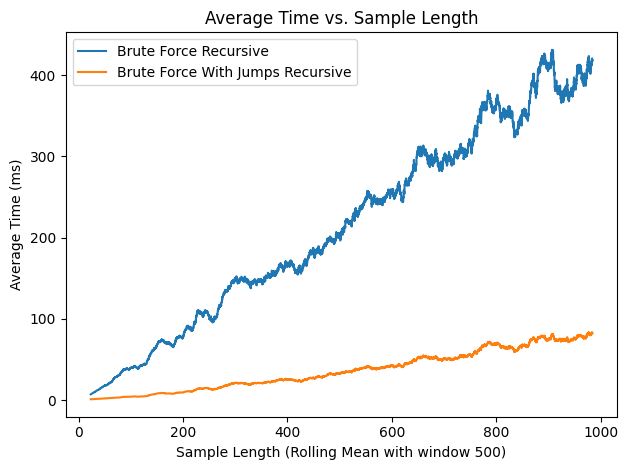

No errors found


In [69]:
data, time_cols, error_cols = prepare_data(['sample-len_20-5-4-30-X.csv', 'bjp_sample-len_20-5-4-30-X.csv'])
time_cols = [col for col in time_cols if 'Pruning' not in col]
error_cols = [col for col in error_cols if 'Pruning' not in col]

# plot_avg(data, time_cols, error_cols, SAMPLE_LENGTH, bucket_size=20)
plot_avg(data, time_cols, error_cols, SAMPLE_LENGTH, rolling_window=500)
plot_error(data, error_cols, SAMPLE_LENGTH)

#### Num Samples

Number of rows: 20000


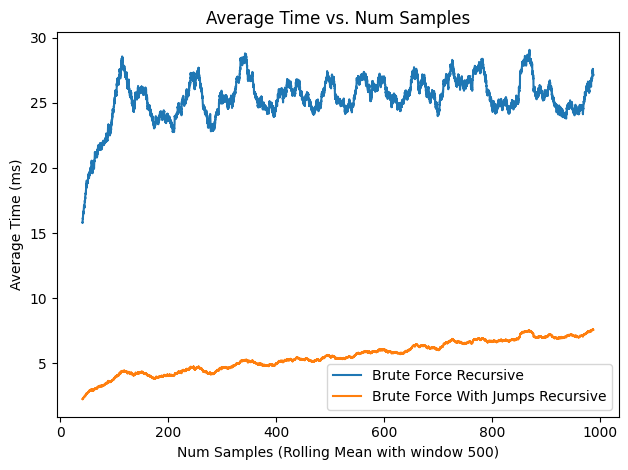

No errors found


In [70]:
data, time_cols, error_cols = prepare_data(['sample-cnt_20-5-4-X-30.csv', 'bjp_samples-cnt_20-5-4-X-30.csv'])
time_cols = [col for col in time_cols if 'Pruning' not in col]
error_cols = [col for col in error_cols if 'Pruning' not in col]

# plot_avg(data, time_cols, error_cols, NUM_SAMPLES, bucket_size=20)
plot_avg(data, time_cols, error_cols, NUM_SAMPLES, rolling_window=500)
plot_error(data, error_cols, NUM_SAMPLES)

Number of rows: 2242


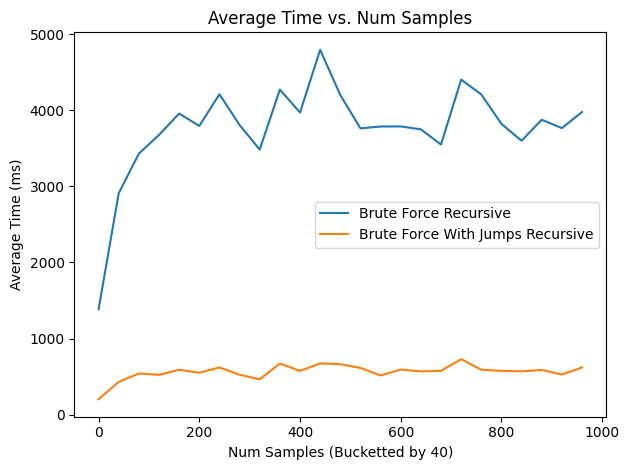

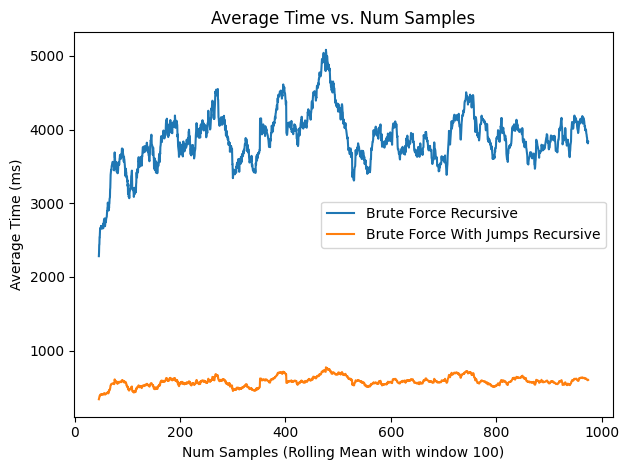

No errors found


In [71]:
data_sample_cnt, time_cols_sample_cnt, error_cols_sample_cnt = prepare_data(['sample-cnt_20-5-5-X-200.csv'])
plot_avg(data_sample_cnt, time_cols_sample_cnt, error_cols_sample_cnt, NUM_SAMPLES, bucket_size=40)
plot_avg(data_sample_cnt, time_cols_sample_cnt, error_cols_sample_cnt, NUM_SAMPLES, rolling_window=100)
plot_error(data_sample_cnt, error_cols_sample_cnt, NUM_SAMPLES)

#### Num States

Number of rows: 3355


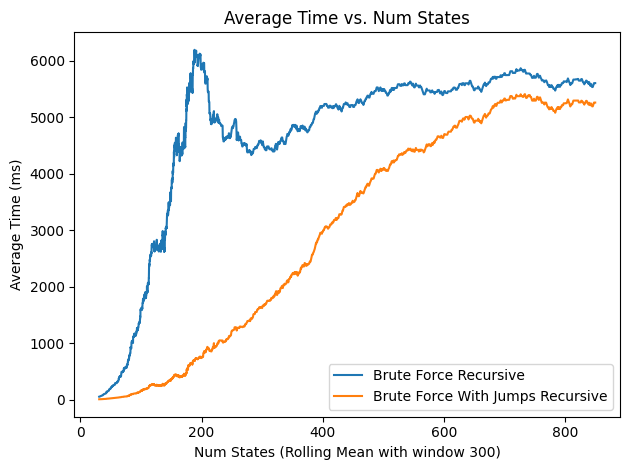

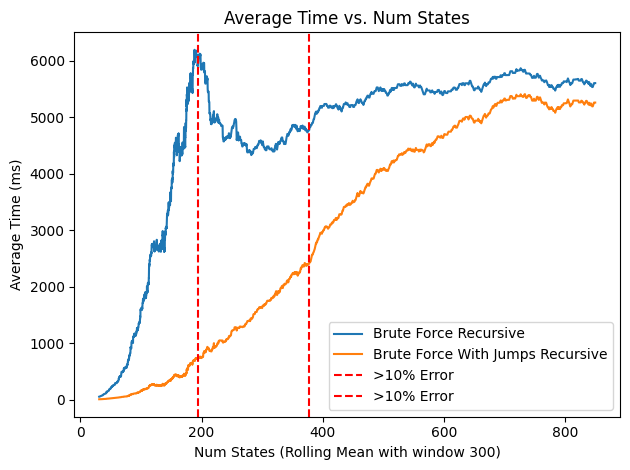

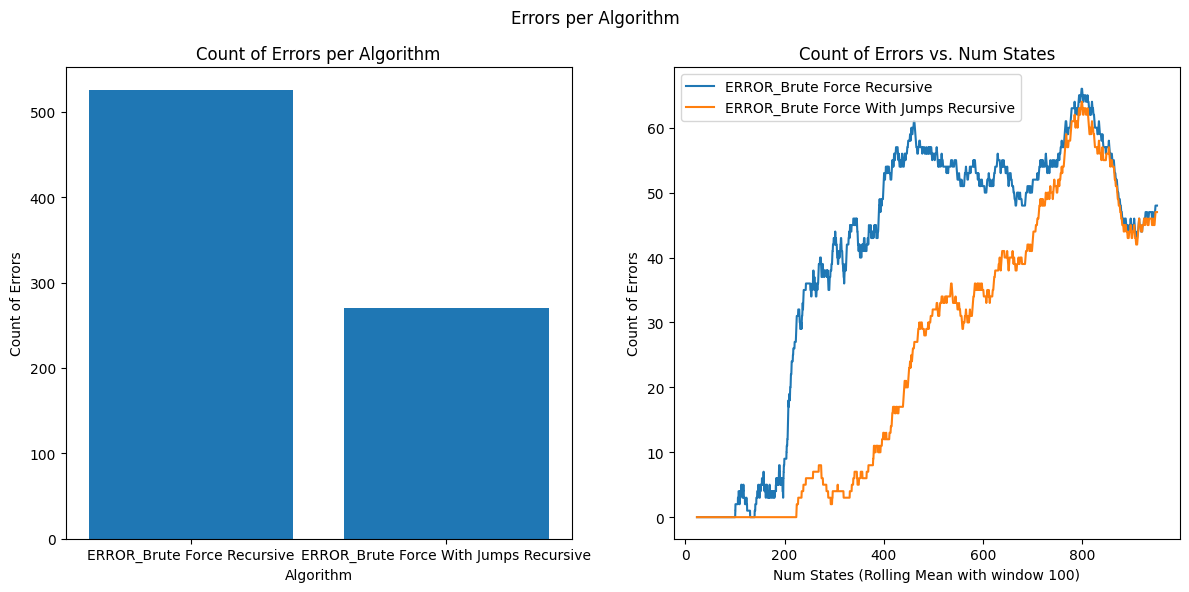

In [72]:
data_num_states, time_cols_num_states, error_cols_num_states = prepare_data(
    ['num-states_X-5-4-30-30.csv', 'num-states2_X-5-4-30-30.csv'],
    skip_error_rows=False
)
# plot_avg(data_num_states, time_cols_num_states, error_cols_num_states, NUM_STATES, bucket_size=15)
plot_avg(data_num_states, time_cols_num_states, error_cols_num_states, NUM_STATES, rolling_window=300)
plot_avg_with_error_thresh(data_num_states, time_cols_num_states, error_cols_num_states, NUM_STATES, thresh_percentage=10, rolling_window=300)
plot_error(data_num_states, error_cols_num_states, NUM_STATES)

#### Missing edges

Number of rows: 767


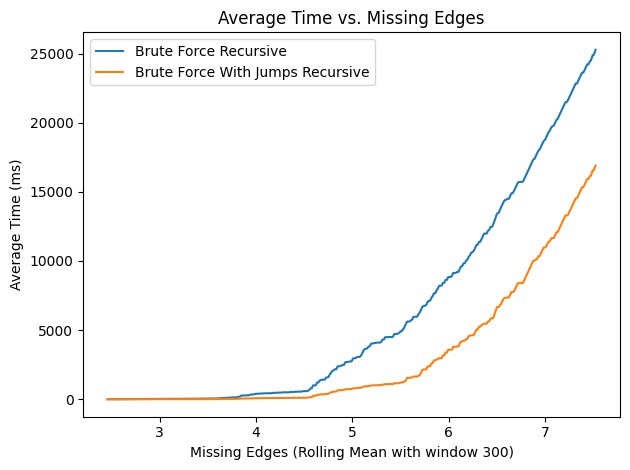

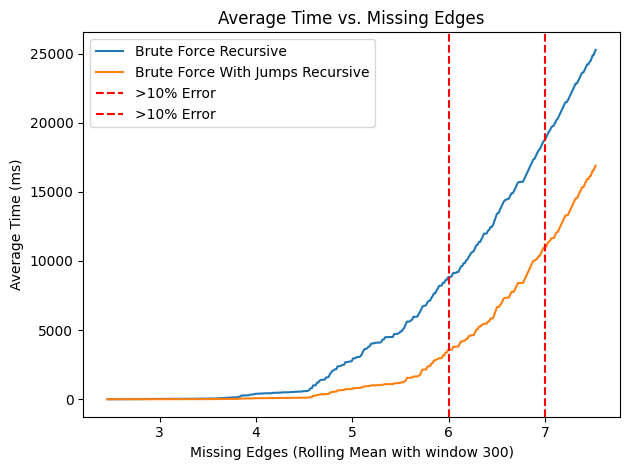

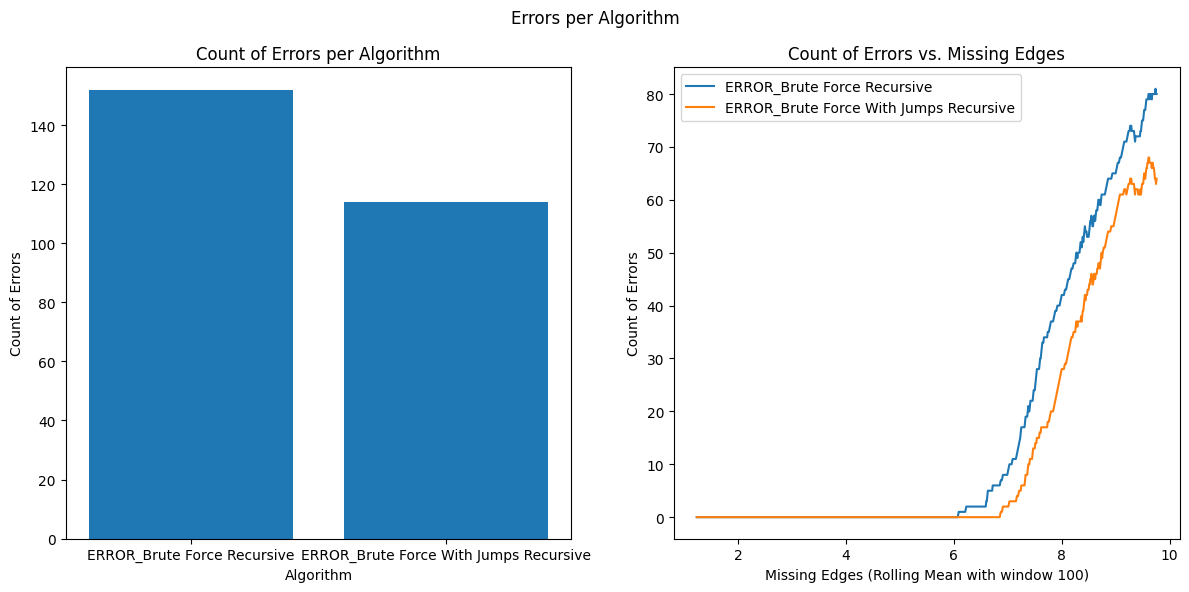

In [73]:
data, time_cols, error_cols = prepare_data(['bjp_missing-edges_20-5-X-30-30.csv'])
time_cols = [col for col in time_cols if 'Pruning' not in col]
error_cols = [col for col in error_cols if 'Pruning' not in col]

plot_avg(data, time_cols, error_cols, MISSING_EDGES, rolling_window=300)
plot_avg_with_error_thresh(data, time_cols, error_cols, MISSING_EDGES, thresh_percentage=10, rolling_window=300)
plot_error(data, error_cols, MISSING_EDGES)

### Brute-Force vs Pruning-style experiment

#### Sample Len

Number of rows: 6465


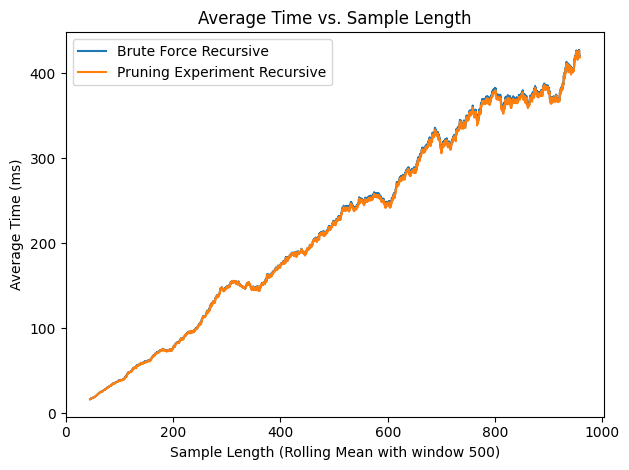

No errors found


In [74]:
data, time_cols, error_cols = prepare_data(['bjp_sample-len_20-5-4-30-X.csv'])
time_cols = [col for col in time_cols if 'Jumps' not in col]
error_cols = [col for col in error_cols if 'Jumps' not in col]

plot_avg(data, time_cols, error_cols, SAMPLE_LENGTH, rolling_window=500)
plot_error(data, error_cols, SAMPLE_LENGTH)

#### Num Samples

Number of rows: 10000


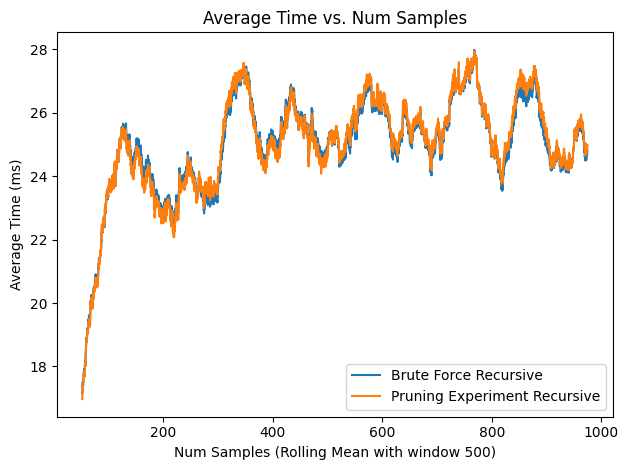

No errors found


In [75]:
data, time_cols, error_cols = prepare_data(['bjp_samples-cnt_20-5-4-X-30.csv'])
time_cols = [col for col in time_cols if 'Jumps' not in col]
error_cols = [col for col in error_cols if 'Jumps' not in col]

plot_avg(data, time_cols, error_cols, NUM_SAMPLES, rolling_window=500)
plot_error(data, error_cols, NUM_SAMPLES)

### Missing edges

Number of rows: 767


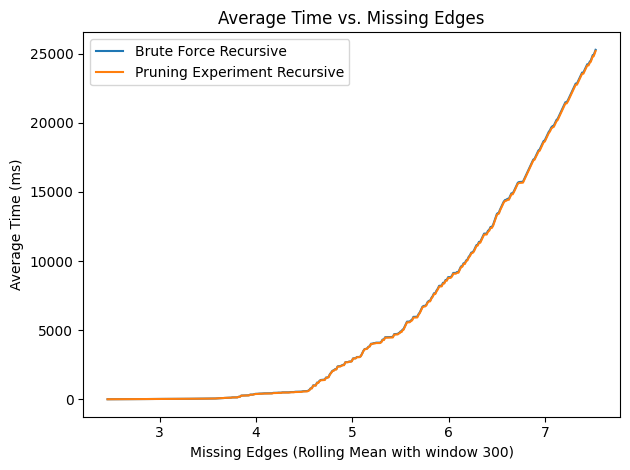

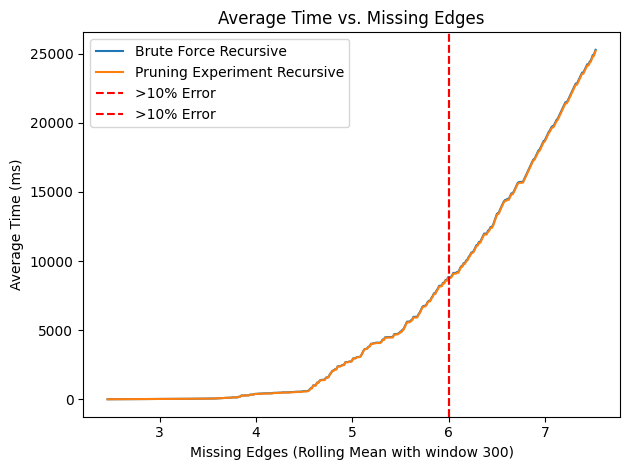

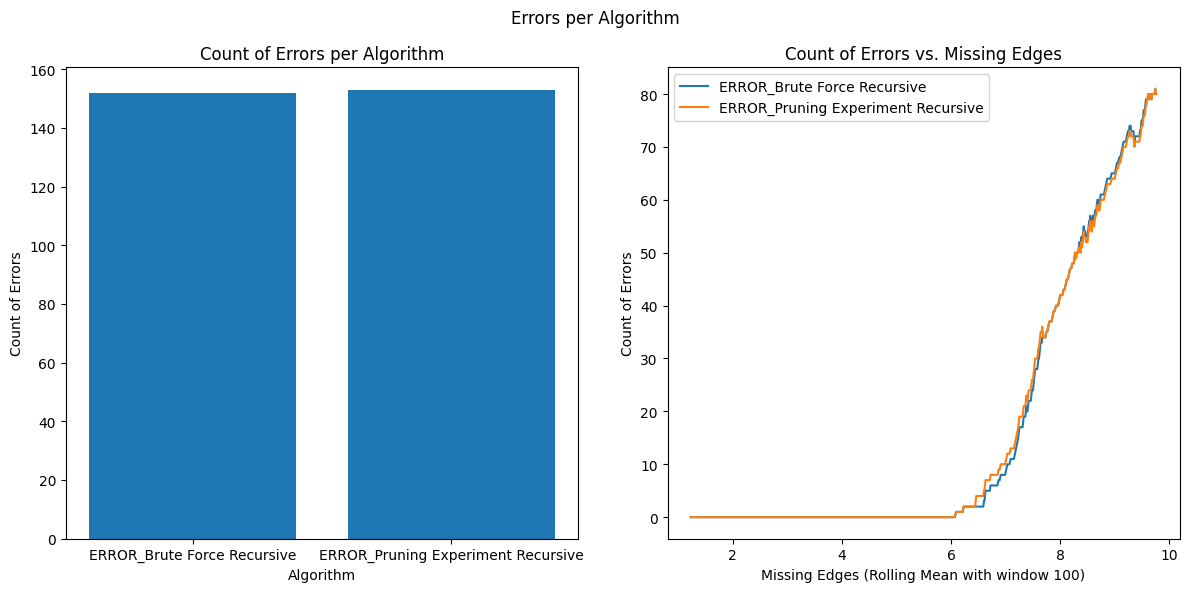

In [76]:
data, time_cols, error_cols = prepare_data(['bjp_missing-edges_20-5-X-30-30.csv'])
time_cols = [col for col in time_cols if 'Jumps' not in col]
error_cols = [col for col in error_cols if 'Jumps' not in col]

plot_avg(data, time_cols, error_cols, MISSING_EDGES, rolling_window=300)
plot_avg_with_error_thresh(data, time_cols, error_cols, MISSING_EDGES, thresh_percentage=10, rolling_window=300)
plot_error(data, error_cols, MISSING_EDGES)